In [1]:
import os
import sys

sys.path.append("..")

import critical_loads as cl
import geopandas as gpd
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
import xarray as xr
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from rasterstats import zonal_stats
from sqlalchemy import text

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads", admin=True)

Username:  ········
Password:  ········


Connection successful.


# Update deposition

We have received annual deposition data for 2017 to 2021 from two sources:

 * **NILU** (see e-mail from Wenche Ås received 14.10.2022 at 14.57). This corresponds to the "old method" for deposition
 
 * **Met.no** (see e-mail from Lewis Blake received 17.02.2023 at 10.17). This corresponds to the "new method" for deposition

This notebook processes the raw data and adds it to the Critical Loads database. In addition, some old data for 1983 to 1992 is also processed and added.

## 1. NILU data ("old method")

The code in this section performs the following calculations:

 1. Reads the raw Numpy arrays from NILU and converts them to an xarray dataset.
 
 2. Calculates average deposition for each parameter over the period 2017 to 2021 inclusive
 
 3. Calculates average values for each BLR grid cell
 
 4. Creates a new deposition series in the database corresponding to 2017 - 2021 (old method)
 
 5. Adds the BLR summaries to the database
 
### 1.1. Read raw data

In [3]:
data_fold = r"/home/jovyan/shared/critical_loads/raster/deposition"

# met.no CRS used by NILU
met_crs = r"+proj=lcc +lat_0=63 +lon_0=15 +lat_1=63 +lat_2=63 +no_defs +R=6.371e+06"

# Example met.no dataset with same geo transfrom etc. (because this wasn't specified by NILU)
met_ds = xr.open_dataset(
    r"https://thredds.met.no/thredds/dodsC/metpplatest/met_forecast_1_0km_nordic_latest.nc"
)

# Read NILU 1km data
pars = ["nh4", "no3", "xso4"]
years = range(2017, 2022)
ds = xr.Dataset({})
for par in pars:
    # Create empty DataArray with correct dims
    da = xr.DataArray(
        dims=("y", "x", "year"),
        coords={"x": met_ds.x, "y": met_ds.y, "year": years},
    )
    da.rio.write_nodata(np.nan, inplace=True)

    # Add NILU data from numpy arrays
    for year in years:
        arr_path = os.path.join(
            data_fold,
            "from_nilu_2022",
            "nilu_dep_2017-21_met_1km_grid",
            f"total_{par}_{year}.npy",
        )
        data = np.load(arr_path)

        # Add values to DataArray
        da.loc[dict(year=year)] = np.flip(data, axis=0)

    # Add DataArray to DataSet
    ds[par] = da

# Update attrs with spatial info from met dataset
ds.rio.write_crs(met_crs, inplace=True,).rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)
ds.rio.write_transform(met_ds.rio.transform())

# Wite example to GeoTIFF for testing in ArcGIS
# ds['nh4'].sel(year=2017).rio.to_raster("test.tif")

ds

<xarray.Dataset>
Dimensions:      (x: 1796, y: 2321, year: 5)
Coordinates:
  * x            (x) float32 -8.974e+05 -8.964e+05 ... 8.966e+05 8.976e+05
  * y            (y) float32 -1.104e+06 -1.103e+06 ... 1.215e+06 1.216e+06
  * year         (year) int64 2017 2018 2019 2020 2021
    spatial_ref  int64 0
Data variables:
    nh4          (y, x, year) float64 nan nan nan nan nan ... nan nan nan nan
    no3          (y, x, year) float64 nan nan nan nan nan ... nan nan nan nan
    xso4         (y, x, year) float64 nan nan nan nan nan ... nan nan nan nan

### 1.2. Average over time

In [4]:
ds_mean = ds.mean(dim="year")

# rasterstats can't handle arrays indexed with increasing 'y', like those
# generated by Verde. See
# https://github.com/perrygeo/python-rasterstats/issues/98
# Flip array and 'y' indices to make compatible
ds_mean = ds_mean.sel(y=slice(None, None, -1))
ds_mean = ds_mean.rio.write_transform()

ds_mean

<xarray.Dataset>
Dimensions:      (x: 1796, y: 2321)
Coordinates:
  * x            (x) float32 -8.974e+05 -8.964e+05 ... 8.966e+05 8.976e+05
  * y            (y) float32 1.216e+06 1.215e+06 ... -1.103e+06 -1.104e+06
    spatial_ref  int64 0
Data variables:
    nh4          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    no3          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    xso4         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

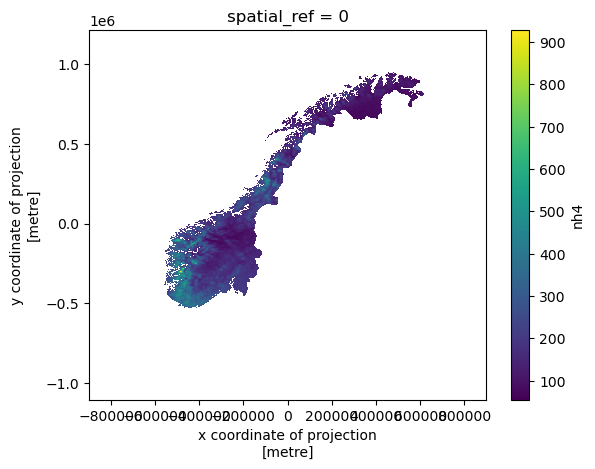

In [5]:
ds_mean["nh4"].plot()

### 1.3. Averages per BLR cell

In [6]:
# Get BLR grid
sql = "SELECT * FROM deposition.dep_grid_blr"
blr_gdf = gpd.read_postgis(sql, eng).to_crs(met_crs)

# Zonal stats
stats = [
    "mean",
]
ndv = -9999
for par in ("nh4", "no3", "xso4"):
    da = ds_mean[par]
    da = da.fillna(ndv)
    da.rio.write_nodata(ndv, inplace=True)
    da.rio.to_raster(
        "temp.tif",
        compress="lzw",
    )

    stats_df = pd.DataFrame(
        zonal_stats(
            vectors=blr_gdf,
            raster="temp.tif",
            stats=stats,
            all_touched=False,
        )
    )
    blr_gdf[par] = stats_df["mean"]

os.remove("temp.tif")
blr_gdf.head()

,cell_id,area_m2,geom,nh4,no3,xso4
0,58005004,5.410322e+07,"MULTIPOLYGON (((-524656.153 -468930.382, -5247...",268.596403,270.652095,268.596403
1,58006001,1.939285e+08,"MULTIPOLYGON (((-510186.409 -480051.140, -5192...",327.146719,335.719936,327.146719
2,58006002,2.044114e+08,"MULTIPOLYGON (((-495695.911 -482006.451, -5101...",402.755758,422.517202,402.755758
3,58006003,2.043394e+08,"MULTIPOLYGON (((-481197.922 -483905.413, -4956...",392.809100,412.196917,392.809100
4,58006004,2.042695e+08,"MULTIPOLYGON (((-466692.659 -485747.996, -4811...",357.694853,377.349592,357.694853


<AxesSubplot:>

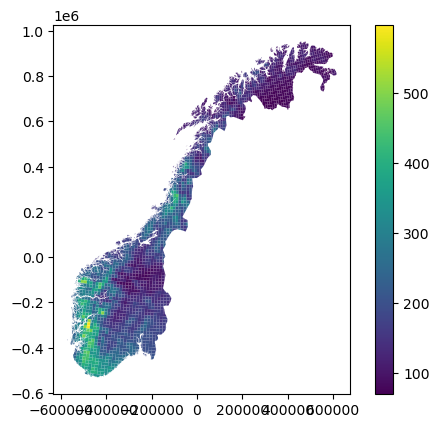

In [7]:
blr_gdf.plot(column="nh4", legend=True)

### 1.4. Create new deposition series in database

In [8]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid.tail())

,series_id,name,short_name,grid,description
62,63,EMEP 2005 b,emep2005b,emep,"2005 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
63,64,EMEP 2010 b,emep2010b,emep,"2010 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
64,65,EMEP 2015 b,emep2015b,emep,"2015 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
65,66,Middel 2017-2021,1721_old,blr,Supplied by NILU in 2022 (Wenche Aas; old method)
66,67,Middel 2017-2021 (new),1721_blrgrid,blr,Supplied by Met in 2023 (Lewis Blake; new method)


In [9]:
# Add new series to database. Edit the variables below to define
# a new row and add it to the table
series_id = 66
long_name = "Middel 2017-2021"
short_name = "1721_old"
grid = "blr"
desc = "Supplied by NILU in 2022 (Wenche Aas; old method)"

# Delete data if already exists
sql = text("DELETE FROM deposition.dep_values_blr_grid WHERE series_id = :series_id")
eng.execute(sql, series_id=series_id)
sql = text("DELETE FROM deposition.dep_series_defs WHERE series_id = :series_id")
eng.execute(sql, series_id=series_id)

# Add new series
cl.add_dep_series(
    series_id,
    long_name,
    short_name,
    grid,
    desc,
    eng,
)

Series added successfully.


### 1.5. Upload dataset

In [10]:
df = pd.DataFrame(blr_gdf.drop(columns=["geom", "area_m2"]))
df.rename({"nh4": 2, "no3": 1, "xso4": 4}, axis="columns", inplace=True)
df = df.melt(id_vars="cell_id", var_name="param_id")
df["series_id"] = series_id
df.head()

,cell_id,param_id,value,series_id
0,58005004,2,268.596403,66
1,58006001,2,327.146719,66
2,58006002,2,402.755758,66
3,58006003,2,392.809100,66
4,58006004,2,357.694853,66


In [11]:
# Add to db
df.to_sql(
    "dep_values_blr_grid",
    con=eng,
    schema="deposition",
    if_exists="append",
    index=False,
    method="multi",
    chunksize=1000,
)

7629

## 2. Met.no data ("new method")

### 2.1. Read raw data

The raw files contain some inconsistencies that are handled below. See e-mail discussion with Lewis Blake 09.03.2023 for details (and the README in the Met raw data folder).

In [12]:
data_fold = r"/home/jovyan/shared/critical_loads/raster/deposition/from_met_2023/WetAndDryDepositions2017-2021"
years = range(2017, 2022)
dep_types = ["DDEP", "WDEP"]
species = ["OXN", "RDN", "SOX"]

df_list = []
for year in years:
    df_ann_list = []
    for dep_type in dep_types:
        for spec in species:
            if dep_type == "DDEP":
                spec_label = f"{spec}_m2Grid"
            else:
                spec_label = spec

            subpath = (
                f"{year}/{dep_type}_{spec_label}/{year}_{dep_type}_{spec_label}.csv"
            )
            fpath = os.path.join(data_fold, subpath)
            df = pd.read_csv(fpath)

            # Raw files are inconsistent as some contain duplicates (from different ensemble memebrs)
            # while others just have the ensemble average. We only need the averages
            df = df.groupby(["lon", "lat"]).mean().reset_index()

            df["year"] = year
            df = df[["lon", "lat", "year", "pred"]]
            df.rename({"pred": f"{dep_type}_{spec}"}, axis="columns", inplace=True)
            df.set_index(["lon", "lat", "year"], inplace=True)
            df_ann_list.append(df)
    ann_df = pd.concat(df_ann_list, axis="columns").reset_index()
    df_list.append(ann_df)
df = pd.concat(df_list, axis="rows")

# Combine vars
df["OXN"] = df["DDEP_OXN"] + df["WDEP_OXN"]
df["RDN"] = df["DDEP_RDN"] + df["WDEP_RDN"]
df["SOX"] = df["DDEP_SOX"] + df["WDEP_SOX"]

# Means for 5-year period
df = df.groupby(["lon", "lat"]).mean().reset_index()
df = df[["lon", "lat", "OXN", "RDN", "SOX"]]

# Rename to match NILU
df.columns = ["lon", "lat", "no3", "nh4", "xso4"]

df.head()

,lon,lat,no3,nh4,xso4
0,-3.255206,71.292015,32.521269,26.218264,59.593065
1,-3.235820,71.270676,32.358157,26.012199,59.569889
2,-3.216474,71.249336,32.336304,25.917564,59.836646
3,-3.197168,71.227997,32.396905,25.887880,60.282277
4,-3.188674,71.298225,32.214904,25.912638,59.593818


In [13]:
# Build GDF. Use the same co-ordinate system as the NILU data (above)
met_crs = r"+proj=lcc +lat_0=63 +lon_0=15 +lat_1=63 +lat_2=63 +no_defs +R=6.371e+06"
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["lon"], df["lat"], crs="EPSG:4326")
).to_crs(met_crs)

# Convert points to raster as netCDF
ds = make_geocube(
    vector_data=gdf, measurements=["no3", "nh4", "xso4"], resolution=(-2500, 2500)
)
ds

<xarray.Dataset>
Dimensions:      (y: 671, x: 531)
Coordinates:
  * y            (y) float64 1.019e+06 1.016e+06 ... -6.538e+05 -6.562e+05
  * x            (x) float64 -6.488e+05 -6.462e+05 ... 6.738e+05 6.762e+05
    spatial_ref  int64 0
Data variables:
    no3          (y, x) float64 32.52 32.21 31.86 31.65 ... 124.5 124.5 123.3
    nh4          (y, x) float64 26.22 25.91 25.55 25.31 ... 147.5 147.7 146.1
    xso4         (y, x) float64 59.59 59.59 59.52 59.62 ... 115.0 115.2 114.8

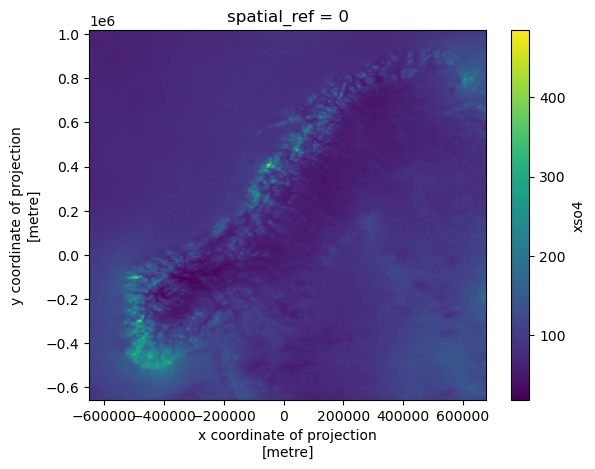

In [14]:
ds["xso4"].plot()

### 2.2. Averages per BLR cell

In [15]:
# Get BLR grid
sql = "SELECT * FROM deposition.dep_grid_blr"
blr_gdf = gpd.read_postgis(sql, eng).to_crs(met_crs)

# Zonal stats
stats = [
    "mean",
]
ndv = -9999
for par in ("nh4", "no3", "xso4"):
    da = ds[par]
    da = da.fillna(ndv)
    da.rio.write_nodata(ndv, inplace=True)
    da.rio.to_raster(
        "temp.tif",
        compress="lzw",
    )

    stats_df = pd.DataFrame(
        zonal_stats(
            vectors=blr_gdf,
            raster="temp.tif",
            stats=stats,
            all_touched=False,
        )
    )
    blr_gdf[par] = stats_df["mean"]

os.remove("temp.tif")
blr_gdf.head()

,cell_id,area_m2,geom,nh4,no3,xso4
0,58005004,5.410322e+07,"MULTIPOLYGON (((-524656.153 -468930.382, -5247...",272.547766,274.344964,160.419529
1,58006001,1.939285e+08,"MULTIPOLYGON (((-510186.409 -480051.140, -5192...",311.174861,323.055617,190.679455
2,58006002,2.044114e+08,"MULTIPOLYGON (((-495695.911 -482006.451, -5101...",374.672698,390.684048,236.764818
3,58006003,2.043394e+08,"MULTIPOLYGON (((-481197.922 -483905.413, -4956...",384.117033,400.838415,249.324659
4,58006004,2.042695e+08,"MULTIPOLYGON (((-466692.659 -485747.996, -4811...",345.865234,358.465445,228.120669


<AxesSubplot:>

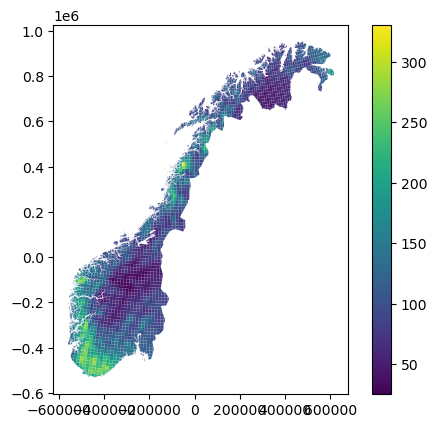

In [16]:
blr_gdf.plot(column="xso4", legend=True)

### 2.3. Create new deposition series in database

In [17]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid.tail())

,series_id,name,short_name,grid,description
62,63,EMEP 2005 b,emep2005b,emep,"2005 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
63,64,EMEP 2010 b,emep2010b,emep,"2010 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
64,65,EMEP 2015 b,emep2015b,emep,"2015 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
65,67,Middel 2017-2021 (new),1721_blrgrid,blr,Supplied by Met in 2023 (Lewis Blake; new method)
66,66,Middel 2017-2021,1721_old,blr,Supplied by NILU in 2022 (Wenche Aas; old method)


In [18]:
# Add new series to database. Edit the variables below to define
# a new row and add it to the table
series_id = 67
long_name = "Middel 2017-2021 (new)"
short_name = "1721_blrgrid"
grid = "blr"
desc = "Supplied by Met in 2023 (Lewis Blake; new method)"

# Delete data if already exists
sql = text("DELETE FROM deposition.dep_values_blr_grid WHERE series_id = :series_id")
eng.execute(sql, series_id=series_id)
sql = text("DELETE FROM deposition.dep_series_defs WHERE series_id = :series_id")
eng.execute(sql, series_id=series_id)

# Add new series
cl.add_dep_series(
    series_id,
    long_name,
    short_name,
    grid,
    desc,
    eng,
)

Series added successfully.


### 2.4. Upload dataset

In [19]:
df = pd.DataFrame(blr_gdf.drop(columns=["geom", "area_m2"]))
df.rename({"nh4": 2, "no3": 1, "xso4": 4}, axis="columns", inplace=True)
df = df.melt(id_vars="cell_id", var_name="param_id")
df["series_id"] = series_id
df.head()

,cell_id,param_id,value,series_id
0,58005004,2,272.547766,67
1,58006001,2,311.174861,67
2,58006002,2,374.672698,67
3,58006003,2,384.117033,67
4,58006004,2,345.865234,67


In [20]:
# Add to db
df.to_sql(
    "dep_values_blr_grid",
    con=eng,
    schema="deposition",
    if_exists="append",
    index=False,
    method="multi",
    chunksize=1000,
)

7629

## 3. Data for 1983 to 1992

For background, see the notebook [here](https://github.com/JamesSample/critical_loads/blob/master/notebooks/processing_1983-1992.ipynb). For the period from 1983 to 1992, we have deposition data from NILU (old method; BLR grid) for SOX anf TOTN (not NH4 and NO3, as usual). This makes the workflow for these period a bit messy. However, Kari has suggested that assuming an even split (i.e. `NH4 = NO3 = 0.5 * TOTN`) may be OK - see e-mail from Kari received 08.03.2023 at 13.23.

The code below processes the data and adds it to the database.

In [21]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid.query("grid == 'blr'"))

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
24,25,Middel 2007-2011,0711,blr,Fordelt til BLR av NILU 2012 (Wenche Aas)
25,26,Middel 2012-2016,1216_old,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; old method)
26,27,Middel 2012-2016 (new),1216_blrgrid,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; new method)
28,29,Middel 1983-1987,8387,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
29,30,Middel 1988-1992,8892,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
65,66,Middel 2017-2021,1721_old,blr,Supplied by NILU in 2022 (Wenche Aas; old method)


The series of interest are already in the database with data for SOX: 1983-87 is series id 29 and 1988-92 is series ID 30.

In [22]:
data_fold = r"/home/jovyan/shared/critical_loads/raster/deposition/from_nilu_2020"
series_dict = {
    "8387": 29,
    "8892": 30,
}

for per, ser_id in series_dict.items():
    fpath = os.path.join(data_fold, f"dep_niva_{per}.dat")
    df = pd.read_csv(fpath, delim_whitespace=True)

    df["RDN"] = 0.5 * df[f"atn{per}"]
    df["OXN"] = 0.5 * df[f"atn{per}"]

    par_dict = {"rutenr": "cell_id", "RDN": 2, "OXN": 1}
    df.rename(par_dict, inplace=True, axis="columns")
    df = df[["cell_id", 1, 2]]
    df = pd.melt(df, var_name="param_id", id_vars="cell_id")
    df["series_id"] = ser_id

    # # Add to db
    # df.to_sql(
    #     "dep_values_blr_grid",
    #     con=eng,
    #     schema="deposition",
    #     if_exists="append",
    #     index=False,
    #     method="multi",
    #     chunksize=1000,
    # )